# Advanced Cryptography — Lab 4 (Side Channel Attacks)

**Author:** Vinicius MOREIRA NASCIMENTO — ENSICAEN, 3A Informatique (CyIA), 2025  
**Course:** Advanced Cryptography  
**Topic:** Correlation Power analysis (CPA) attacks in Elliptic Curves.

## Data for the lab. 
The first file plaintext.npy contains N plaintexts, where each plaintext is represented by an array of 16 bytes (128 bits). These plaintext have been encrypted with ES using the same key (the ciphertexts are not given). The second file traces.npy contains N = 50 power traces, with N ′ = 9996 points for each trace. These traces have been acquired during the encryption. The objective of this lab is to recover this key by implementing a CPA attack (Correlation Power Analysis) on the first round of the AES (after SubBytes).

In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

filename1 = "./data_Lab5/traces.npy"
filename2 = "./data_Lab5/plaintext.npy"

In [2]:
def bitstring_to_bytes(s):
    v = int(s, 2)
    b = bytearray()
    while v:
        b.append(v & 0xff)
        v >>= 8
    return bytes(b[::-1])

Data of the two previous files are recovered from the load function of numpy. Verify that len(traces) returns 50 and len(traces[0]) returns 9996

In [3]:
traces = np.load(filename1)
plaintext = np.load(filename2)

print(len(traces))
print(len(traces[0]))
print(len(plaintext))
print(len(plaintext[0]))

50
9996
50
16


You can visualize the first trace using (delete these three lines after use)

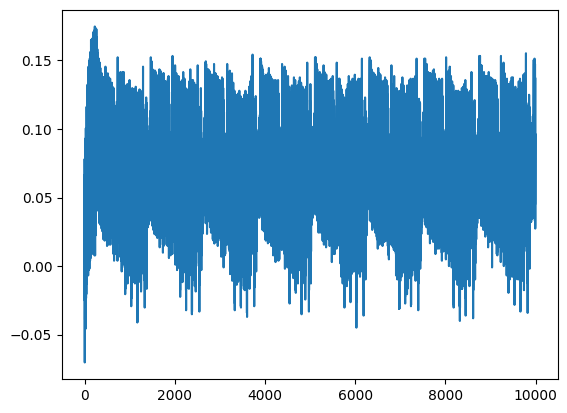

In [4]:
plt.plot(traces[0])
plt.show()

In [5]:
sbox = [
            0x63,0x7c,0x77,0x7b,0xf2,0x6b,0x6f,0xc5,0x30,0x01,0x67,0x2b,0xfe,0xd7,0xab,0x76,
            0xca,0x82,0xc9,0x7d,0xfa,0x59,0x47,0xf0,0xad,0xd4,0xa2,0xaf,0x9c,0xa4,0x72,0xc0,
            0xb7,0xfd,0x93,0x26,0x36,0x3f,0xf7,0xcc,0x34,0xa5,0xe5,0xf1,0x71,0xd8,0x31,0x15,
            0x04,0xc7,0x23,0xc3,0x18,0x96,0x05,0x9a,0x07,0x12,0x80,0xe2,0xeb,0x27,0xb2,0x75,
            0x09,0x83,0x2c,0x1a,0x1b,0x6e,0x5a,0xa0,0x52,0x3b,0xd6,0xb3,0x29,0xe3,0x2f,0x84,
            0x53,0xd1,0x00,0xed,0x20,0xfc,0xb1,0x5b,0x6a,0xcb,0xbe,0x39,0x4a,0x4c,0x58,0xcf,
            0xd0,0xef,0xaa,0xfb,0x43,0x4d,0x33,0x85,0x45,0xf9,0x02,0x7f,0x50,0x3c,0x9f,0xa8,
            0x51,0xa3,0x40,0x8f,0x92,0x9d,0x38,0xf5,0xbc,0xb6,0xda,0x21,0x10,0xff,0xf3,0xd2,
            0xcd,0x0c,0x13,0xec,0x5f,0x97,0x44,0x17,0xc4,0xa7,0x7e,0x3d,0x64,0x5d,0x19,0x73,
            0x60,0x81,0x4f,0xdc,0x22,0x2a,0x90,0x88,0x46,0xee,0xb8,0x14,0xde,0x5e,0x0b,0xdb,
            0xe0,0x32,0x3a,0x0a,0x49,0x06,0x24,0x5c,0xc2,0xd3,0xac,0x62,0x91,0x95,0xe4,0x79,
            0xe7,0xc8,0x37,0x6d,0x8d,0xd5,0x4e,0xa9,0x6c,0x56,0xf4,0xea,0x65,0x7a,0xae,0x08,
            0xba,0x78,0x25,0x2e,0x1c,0xa6,0xb4,0xc6,0xe8,0xdd,0x74,0x1f,0x4b,0xbd,0x8b,0x8a,
            0x70,0x3e,0xb5,0x66,0x48,0x03,0xf6,0x0e,0x61,0x35,0x57,0xb9,0x86,0xc1,0x1d,0x9e,
            0xe1,0xf8,0x98,0x11,0x69,0xd9,0x8e,0x94,0x9b,0x1e,0x87,0xe9,0xce,0x55,0x28,0xdf,
            0x8c,0xa1,0x89,0x0d,0xbf,0xe6,0x42,0x68,0x41,0x99,0x2d,0x0f,0xb0,0x54,0xbb,0x16
        ]

HW = np.array([bin(i).count("1") for i in range(256)], dtype=np.uint8)

**CPA attack:** The attack is performed on each byte $K_j$ of the key $K$ ($j$ is between 0 and 15, but you can begin by $j = 0$, and add a loop in a second time). Let $W'_{i,l}$ be the $l$-th point of the $i$-th power trace (consequently $i$ is between 0 and $N − 1$, whereas $l$ is between 0 and $N' − 1$).

Compute $\overline{W'_l}$ , the mean (on $i$) of these points, represented by an array of size $N'$, which is independent from the hypothesis on the key. Remark : look the good numpy function for this.

In [6]:
traces_mean = np.mean(traces, axis=0)                       # shape (N0,)
traces_centered = traces - traces_mean[None, :]             # shape (N, N0)
sum2 = np.sum(traces_centered * traces_centered, axis=0)    # shape (N0,)

eps = 1e-12
recovered = np.zeros(16, dtype=np.uint8)

For each hypothesis $k$ on the byte $K_j$ (among the 256 possibilities), we compute the *Pearson coefficients* between the *power traces* and the *Hamming weight of the output of the S-box*. More precisely, the $max$ of these coefficients (called $maxcpa$) should be computed. Thus, $maxcpa$ is an array of size $256$ and the good hypothesis on $K_j$ is the index of $maxcpa$ with the *greatest value* (look at the good numpy function for this). More precisely, for each hypothesis $k$ on $K_j$ :

The attack is performed on each byte $K_j$ of the key $K$ (j is between 0 and 15)

In [7]:
for j in range(16):
    pt = plaintext[:, j].astype(np.uint8)   # shape (N,)
    maxcpa = np.zeros(256, dtype=np.float64)

    for k in range(256):
        preds = [sbox[x ^ k] for x in pt]
        preds = np.array(preds, dtype=np.uint8)
        pred_hw = HW[preds].astype(np.float64)  # shape (N,)
        # If prediction is constant, correlation is zero (skip)
        if np.all(pred_hw == pred_hw[0]):
            maxcpa[k] = 0.0
            continue
        h = pred_hw - pred_hw.mean()            # shape (N,)
        sum1 = h @ traces_centered              # shape (N0,)
        sum3 = np.sum(h * h)                    # scalar
        den = np.sqrt(sum3 + eps) * np.sqrt(sum2 + eps)  # shape (N0,)
        r_k = sum1 / den
        r_k = np.nan_to_num(r_k, nan=0.0, posinf=0.0, neginf=0.0)
        maxcpa[k] = np.max(np.abs(r_k))

    recovered[j] = int(np.argmax(maxcpa))

In [8]:
# format recovered key and compare with expected
recovered_hex = ''.join(f"{b:02x}" for b in recovered)
expected_hex = "98a90ac6a2bc26493c3be04b113555d4"  # expected value from exercise
print("Recovered key (hex):", recovered_hex)
print("Expected  key (hex):", expected_hex)
print("Match:", recovered_hex == expected_hex)

Recovered key (hex): 98a90ac6a2bc26493c3be04b113555d4
Expected  key (hex): 98a90ac6a2bc26493c3be04b113555d4
Match: True
